In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Sequence Classification using Recurrent Neural Networks(RNN)
In this homework, you will learn how to train a recurrent neural network for human action classification. RNN is designed handle sequential data. The network can incorporate both past history and current input. [This](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) is a very good tutorial. You should read it before you start.

## Setup
Please make sure you have h5py and torchnet installed
> pip install h5py

> pip install git+https://github.com/pytorch/tnt.git@master


In [2]:
!pip install torchnet

     |████████████████████████████████| 686kB 11.3MB/s 
     |████████████████████████████████| 204kB 53.4MB/s 
  Created wheel for torchnet: filename=torchnet-0.0.4-cp27-none-any.whl size=29743 sha256=e105729c346badcea88d15a6ed71f4fa8a4830792d724fea0130ecb8f5f3ba31
  Stored in directory: /root/.cache/pip/wheels/e1/03/fb/1c212c2f20905cdf97fe39022946cf16b8e66ed754a6663400
  Created wheel for visdom: filename=visdom-0.1.8.9-cp27-none-any.whl size=655250 sha256=0403a3eb2018e68ac7deee1d1d8941e212dfccc5fa97ba0b08d848fe8f5a3258
  Stored in directory: /root/.cache/pip/wheels/70/19/a7/6d589ed967f4dfefd33bc166d081257bd4ed0cb618dccfd62a
  Created wheel for torchfile: filename=torchfile-0.1.0-cp27-none-any.whl size=5713 sha256=3e66c9dee92fe67ecbba04fb7db202ebb41361de8b2386e41b194b99e876cf1e
  Stored in directory: /root/.cache/pip/wheels/b1/c3/d6/9a1cc8f3a99a0fc1124cae20153f36af59a6e683daca0a0814
Successfully built torchnet visdom torchfile


In [3]:
import os
import numpy as np
import h5py

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as DD
import torchnet as tnt

use_cuda = False
print('use cuda: %s'%(use_cuda))
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor

use cuda: False


## Dataset
The data we are using is skeleton data, which indicates the 3D locations of body joints. In total, there are 25 body joints. It is collected by Kinect v2. To make it easier, each sequence have same number of frames. You need to classify 10 different actions. There are 2000 training sequences, 400 validation sequences, and 500 test sequences. Each sequence has 15 frames, each frame is a 75-dimension vector (3*25). 

For your convenience, we provide the dataloader for you.


In [0]:
class Dataset(DD.Dataset):
    # subset can be: 'train', 'val', 'test'
    def __init__(self, data_path, subset='train'):
        super(Dataset, self).__init__()
        self.data_path = os.path.join(data_path, '%s_data.h5'%subset)
        self.subset = subset

        with h5py.File(self.data_path) as f:
            self.data = np.array(f['data'])

        if subset != 'test':
            self.label_path = os.path.join(data_path, '%s_label.h5'%subset)
            with h5py.File(self.label_path) as f:
                self.label = np.array(f['label'])

        self.num_sequences = self.data.shape[0]
        self.seq_len = self.data.shape[1]
        self.n_dim = self.data.shape[2]

    def __getitem__(self, index):
        seq = self.data[index]
        if self.subset != 'test':
            label = int(self.label[index])
            sample = {'seq': seq, 'label': label}
        else:
            sample = {'seq': seq}
        return sample

    def __len__(self):
        return self.num_sequences

trSet = Dataset('/content/drive/My Drive/HW6ML/ques3_data/', subset='train')
valSet = Dataset('/content/drive/My Drive/HW6ML/ques3_data/', subset='val')
tstSet = Dataset('/content/drive/My Drive/HW6ML/ques3_data/', subset='test')

batch_size = 100
trLD = DD.DataLoader(trSet, batch_size=batch_size,
       sampler=DD.sampler.RandomSampler(trSet),
       num_workers=2, pin_memory=False)
valLD = DD.DataLoader(valSet, batch_size=batch_size,
       sampler=DD.sampler.SequentialSampler(valSet),
       num_workers=1, pin_memory=False)
tstLD = DD.DataLoader(tstSet, batch_size=batch_size,
       sampler=DD.sampler.SequentialSampler(tstSet),
       num_workers=1, pin_memory=False)

input_dim = trSet.n_dim
num_class = 10

## Model
Pytorch has implemented different types of recurrent layers for you. For this homework, you can use any type of RNNs as you want:
> torch.nn.RNN()

> torch.nn.LSTM()

> torch.nn.GRU()

You can check details for different types of recurrent layers here: [RNN](http://pytorch.org/docs/master/nn.html#torch.nn.RNN), [LSTM]( http://pytorch.org/docs/master/nn.html#torch.nn.LSTM), [GRU](http://pytorch.org/docs/master/nn.html#torch.nn.GRU)


### Implement a specific model
In this section, you need to implement a model for sequence classification. The model has following layers:
* A linear layer that can map features of 75-dimension to 100-dimension.
* 1 Layer LSTM layer with hidden size of 100
* A linear layer that goes from 100 to num_class (10). 

An LSTM layer takes an input of size of (batch_size, seq_len, fea_dim) and outputs a variable of shape (batch_size, seq_len, hidden_size). In this homework, the classification score for a sequence is the classification score for the last step of rnn_outputs.



In [0]:
global loss_training, loss_validation, accuracy_training, accuracy_validation
loss_training = [] 
loss_validation=[] 
accuracy_training=[] 
accuracy_validation = [] 

In [0]:
# sequence classification model
class SequenceClassify(nn.Module):
    def __init__(self):
        super(SequenceClassify, self).__init__()
        
        ############## 1st To Do (10 points) ##############
        ###################################################
        self.project_layer = nn.Linear(75, 100)
        self.recurrent_layer = nn.LSTM(100, 100, 2)
        self.classify_layer = nn.Linear(100, num_class)
        ###################################################
    
    # the size of input is [batch_size, seq_len(15), input_dim(75)]
    # the size of logits is [batch_size, num_class]
    def forward(self, input, h_t_1=None, c_t_1=None):
        # the size of rnn_outputs is [batch_size, seq_len, rnn_size]
        rnn_outputs, (hn, cn) = self.recurrent_layer(self.project_layer(input))
        # classify the last step of rnn_outpus
        # the size of logits is [batch_size, num_class]
        logits = self.classify_layer(rnn_outputs[:,-1])
        return logits

model = SequenceClassify()

## Train the model
After you have the dataloader and model, you can start training the model. Define a SGD optimizer with learning rate of 1e-3, and a cross-entropy loss function:

In [0]:
################ 2nd To Do  (5 points)##################
optimizer = torch.optim.SGD(model.parameters(), lr = 1e-4)
criterion = nn.CrossEntropyLoss()

In [8]:
# run the model for one epoch
# can be used for both training or validation model
def run_epoch(data_loader, model, criterion, epoch, is_training, optimizer=None):
    if is_training:
        model.train()
        logger_prefix = 'train'
    else:
        model.eval()
        logger_prefix = 'val'

    confusion_matrix = tnt.meter.ConfusionMeter(num_class)
    acc = tnt.meter.ClassErrorMeter(accuracy=True)
    meter_loss = tnt.meter.AverageValueMeter()

    for batch_idx, sample in enumerate(data_loader):
        sequence = sample['seq']
        label = sample['label']
        input_sequence_var = Variable(sequence).type(FloatTensor)
        input_label_var = Variable(label).type(LongTensor)

        # compute output
        # output_logits: [batch_size, num_class]
        output_logits = model(input_sequence_var)
        loss = criterion(output_logits, input_label_var)

        if is_training:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        meter_loss.add(loss.data)
        acc.add(output_logits.data, input_label_var.data)
        confusion_matrix.add(output_logits.data, input_label_var.data)
    global max_accu
    global loss_training
    global accuracy_training
    global loss_validation
    global accuracy_validation

    print('%s Epoch: %d  , Loss: %.4f,  Accuracy: %.2f'%(logger_prefix, epoch, meter_loss.value()[0], acc.value()[0]))
    if logger_prefix == 'train':
        loss_training.append(meter_loss.value()[0])
        accuracy_training.append(acc.value()[0])
    else:
        loss_validation.append(meter_loss.value()[0])
        accuracy_validation.append(acc.value()[0])
    return acc.value()[0]

num_epochs = 1
evaluate_every_epoch = 5
train_loss = np.zeros(num_epochs)
val_loss = np.zeros(num_epochs/evaluate_every_epoch)
train_accuracy = np.zeros(num_epochs)
val_accuracy = np.zeros(num_epochs/evaluate_every_epoch)
for e in range(num_epochs):
     run_epoch(trLD, model, criterion, e, True, optimizer)
     if e % evaluate_every_epoch == 0:
       run_epoch(valLD, model, criterion, e, False, None)   

train Epoch: 0  , Loss: 2.3043,  Accuracy: 9.80
val Epoch: 0  , Loss: 2.3051,  Accuracy: 10.00


In [0]:
# 2nd attempt at creating model
class SequenceClassify(nn.Module):
    def __init__(self):
        super(SequenceClassify, self).__init__()
        
        ############## 1st To Do (10 points) ##############
        ###################################################
        self.project_layer = nn.Linear(75, 100)
        #self.recurrent_layer = nn.LSTM(100, 200, 2, bidirectional=True) 
        self.recurrent_layer = nn.LSTM(100, 100, 2, bidirectional=True) #79% @ Epoch 30
        #self.classify_layer = nn.Linear(400, num_class)
        self.classify_layer = nn.Linear(3000, num_class)
        ###################################################
    
    # the size of input is [batch_size, seq_len(15), input_dim(75)]
    # the size of logits is [batch_size, num_class]
    def forward(self, input, h_t_1=None, c_t_1=None):
        # the size of rnn_outputs is [batch_size, seq_len, rnn_size]
        rnn_outputs, (hn, cn) = self.recurrent_layer(self.project_layer(input))
        # classify the last step of rnn_outpus
        # the size of logits is [batch_size, num_class]
        rnn_outputs_reshape = rnn_outputs.view(100, -1)
        #logits = self.classify_layer(rnn_outputs[:,-1])
        logits = self.classify_layer(rnn_outputs_reshape)
        return logits

model = SequenceClassify()

In [0]:
################ 2nd To Do  (5 points)##################
#optimizer = torch.optim.SGD(model.parameters(), lr = 1e-4) Result - almost no change in accuracy results 
#optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) 
#optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) #Result - 40% at 75 epochs
#optimizer = torch.optim.Adam(model.parameters(), lr=1e-2) Result - 38% at 75 epochs
#torch.optim.Adadelta(model.parameters(), lr = 0.003) #Result - 42.75 at 50 epochs 
#optimizer = torch.optim.Adam(model.parameters(), lr=0.002)
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
criterion = nn.CrossEntropyLoss().type(FloatTensor)

In [11]:
num_epochs = 75
evaluate_every_epoch = 1
for e in range(num_epochs):
    run_epoch(trLD, model, criterion, e, True, optimizer)
    if e % evaluate_every_epoch == 0:
        run_epoch(valLD, model, criterion, e, False, None)  

train Epoch: 0  , Loss: 2.3376,  Accuracy: 10.80
val Epoch: 0  , Loss: 2.2848,  Accuracy: 12.00
train Epoch: 1  , Loss: 2.1903,  Accuracy: 18.00
val Epoch: 1  , Loss: 1.9136,  Accuracy: 29.75
train Epoch: 2  , Loss: 1.6919,  Accuracy: 38.25
val Epoch: 2  , Loss: 1.3883,  Accuracy: 50.75
train Epoch: 3  , Loss: 1.2816,  Accuracy: 53.80
val Epoch: 3  , Loss: 1.0780,  Accuracy: 61.00
train Epoch: 4  , Loss: 1.0722,  Accuracy: 63.10
val Epoch: 4  , Loss: 1.0109,  Accuracy: 65.50
train Epoch: 5  , Loss: 0.9870,  Accuracy: 66.30
val Epoch: 5  , Loss: 0.9788,  Accuracy: 68.25
train Epoch: 6  , Loss: 0.8707,  Accuracy: 69.15
val Epoch: 6  , Loss: 0.8436,  Accuracy: 70.75
train Epoch: 7  , Loss: 0.7825,  Accuracy: 71.90
val Epoch: 7  , Loss: 0.8230,  Accuracy: 71.00
train Epoch: 8  , Loss: 0.7647,  Accuracy: 73.05
val Epoch: 8  , Loss: 0.7924,  Accuracy: 74.50
train Epoch: 9  , Loss: 0.7078,  Accuracy: 75.65
val Epoch: 9  , Loss: 0.7356,  Accuracy: 77.00
train Epoch: 10  , Loss: 0.6222,  Accura

## Submit your results 

### Train a better model for action recognition!
Now it's your job to experiment with architectures, hyperparameters, loss functions, and optimizers to train a model that achieves better accuracy on the action recognition validation set. 


### Testing the model and reporting the results
Test the model on the testing set and save the results as a .csv file. 
submit the results.csv file generated by predict_on_test(). Also mention the best performance on the Validation set, and submit the corresponding results csv file which results in the best performance. 
################ 3rd To Do  (15 points) ###############


In [26]:
# Use your best model to generate results on test set and validation set.

# generate csv file for test set
def predict_on_test(model, data_loader):
    model.eval() # Put the model in test mode (the opposite of model.train(), essentially)
    results=open('results.csv','w')
    count=0
    results.write('Id'+','+'Class'+'\n')
    for batch_idx, sample in enumerate(data_loader):
        sequence = sample['seq']
        input_sequence_var = Variable(sequence).type(FloatTensor)
        scores = model(input_sequence_var)
        _, preds = scores.data.max(1)
        for i in range(len(preds)):
            results.write(str(count)+','+str(preds[i].item())+'\n')
            count+=1
    results.close()
    return count

count=predict_on_test(model, tstLD)
print(count)

500


In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
epochs = []
for i in range(1, 77):
    epochs.append(i)

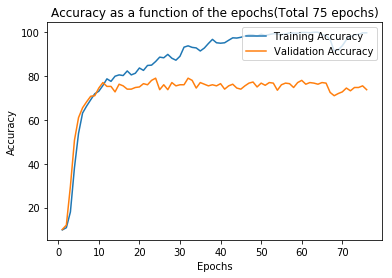

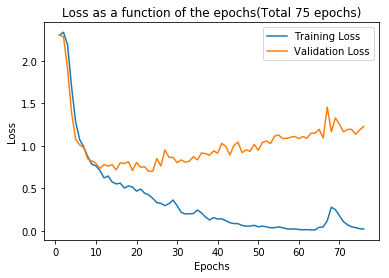

In [25]:
plot1 = plt.plot(epochs, accuracy_training)
plot2 = plt.plot(epochs, accuracy_validation)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy as a function of the epochs(Total 75 epochs)")
plt.legend(["Training Accuracy", "Validation Accuracy"], loc = 1)
plt.show()


plot3 = plt.plot(epochs, loss_training)
plot4 = plt.plot(epochs, loss_validation)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss as a function of the epochs(Total 75 epochs)")
plt.legend(["Training Loss", "Validation Loss"], loc = 1)
plt.show()

## Report the performance
################ 4th To Do  (5 points)##################

In this cell, you should write an explanation of what you did (network architecture, optimiziter, learning rate, epoches) and any visualizations or graphs that you make in the process of training and evaluating your network.



## I made the following updates to the setup:



*   Increased the Batch size to 100 items: I observed that the processing was slower with a batch size of 50(default value)
*   Removed all cuda elements, this exercise was done without GPU support. 
* For the model, I used a bidirectional LSTM with 2 layers and the size of the hidden layer as 100. I had experimented with different parameters for layer sizes and number of layers and found that this performed the best.
* For the classify layers I changed the the number of input classes and then used view() to reshape this layer. This resulted in a faster reduction in loss values in my experience. 
* I used the Adam Optimiser function with a learning rate of 0.003. I experimented with different values(Refer the cell for optimiser definition) and found these parameters to produce the best results 
* I ran the setup for 75 epochs.

**Observations and final results**: 
At Epoch 30, the maximum validation accuracy percentage was attained at 79%
Maximum training data accuracy was attained at epoch 62 @ 99.95% 

The same can be referred from the Loss v/s Epoch and Accuracy v/s Epoch plots in the cell above.

